<a href="https://colab.research.google.com/github/cbg11/Playing-2048-Game-Using-RL-Agent/blob/main/2048_with_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
# Path to save file
import pathlib
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
%cd /content/drive/My Drive/RL_project

Mounted at /content/drive/
/content/drive/My Drive/RL_project


In [3]:
class Game:
    def __init__(self):
        self.board = np.zeros((4, 4), dtype=np.int32)
        self.score = 0
        self.game_over = False
        self.add_tile()
        self.add_tile()

    def add_tile(self):
        empty_cells = np.where(self.board == 0)
        if len(empty_cells[0]) == 0:
            return
        idx = random.choice(range(len(empty_cells[0])))
        value = 2 if random.random() < 0.9 else 4
        self.board[empty_cells[0][idx], empty_cells[1][idx]] = value

    def move(self, direction):
        if direction == 'left':
            self.board, moved, reward = move_left(self.board)
        elif direction == 'right':
            self.board, moved, reward = move_right(self.board)
        elif direction == 'up':
            self.board, moved, reward = move_up(self.board)
        elif direction == 'down':
            self.board, moved, reward = move_down(self.board)

        if moved:
            self.add_tile()
            self.score += reward
        if (np.count_nonzero(self.board) == 16) and (np.all(self.board[:, :-1] != self.board[:, 1:]) and np.all(self.board[:-1, :] != self.board[1:, :])):
            self.game_over = True
        return moved, reward


In [4]:
class DQNAgent:
    def __init__(self, n_observations = 16, action_size = 4, gamma=0.99, epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.01, learning_rate=0.001, memory_size=100_000):
        self.n_observations = n_observations
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.learning_rate = learning_rate
        self.memory = []
        self.memory_size = memory_size
        self.model = DQN(self.n_observations,self.action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.memory_size:
            del self.memory[0]

    def act(self, state, epsilon = None):
        if epsilon == None:
          epsilon = self.epsilon
        else:
          epsilon = epsilon
        if np.random.rand() < epsilon:
            # Explore
            return random.randrange(self.action_size)
        else:
            # Exploit best known action
            state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = self.model(state)
            return torch.argmax(q_values, dim=1).item()


    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        q_values = self.model(states).gather(1, actions)
        next_q_values = self.model(next_states)
        max_next_q_values = torch.max(next_q_values, dim=1, keepdim=True)[0]
        expected_q_values = rewards + self.gamma * max_next_q_values * (1 - dones)
        loss = self.loss_fn(q_values, expected_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        if self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay

In [6]:
class DQN(nn.Module):
  def __init__(self, n_observations, action_size):
    super(DQN, self).__init__()
    self.fc1 = nn.Linear(n_observations, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, action_size)

  def forward(self, x):
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = self.fc3(x)
    return x

def preprocess(board):
  # Convert the board to a 1D array and take the logarithm of each tile value
  board = np.log2(board.flatten() + 1)
  # Normalize the board to have zero mean and unit variance
  board = (board - board.mean()) / board.std()
  return board
  
def move_left(board):
  moved = False
  score = 0
  for row in range(4):
    merged = np.zeros((4,), dtype=bool)
    for col in range(1, 4):
      if board[row, col] == 0:
        continue
      for i in range(col):
        if board[row, i] == 0:
          board[row, i] = board[row, col]
          board[row, col] = 0
          moved = True
          break
        elif board[row, i] == board[row, col] and not merged[i]:
          board[row, i] *= 2
          board[row, col] = 0
          merged[i] = True
          moved = True
          score += board[row, i]
          break
  return board, moved, score

def move_right(board):
  board, moved, score = move_left(np.fliplr(board))
  return np.fliplr(board), moved, score
    
def move_up(board):
  board, moved, score = move_left(board.T)
  return board.T, moved, score

def move_down(board):
  board, moved, score = move_right(board.T)
  return board.T, moved, score

def train(agent, episodes, batch_size):
  scores = []
  for episode in range(episodes):
      game = Game()
      state = preprocess(game.board)
      done = False
      while not done:
        action = agent.act(state)
        moved, reward = game.move(['left', 'up', 'right', 'down'][action])
        while not moved:
          rand_num = action
          while rand_num == action:
            rand_num = random.randrange(4)
          action = rand_num
          moved, reward = game.move(['left', 'up', 'right', 'down'][action])
        next_state = preprocess(game.board)
        done = game.game_over
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        agent.replay(batch_size)
      #print(game.board)
      scores.append(game.score)
      max_val = max(max(row) for row in game.board)
      print("Episode: %d, Score: %d, Max Value: %d Epsilon: %.4f" % (episode, game.score, max_val, agent.epsilon))
      if episode % 500 == 0:
        torch.save(agent.model.state_dict(), 'model.pth')
  return scores

In [ ]:
if __name__ == '__main__':
  n_observations = 16
  action_size = 4
  agent = DQNAgent(n_observations, action_size, gamma=0.999)
  scores = train(agent, episodes=5001, batch_size=32)
  print("done")

In [23]:
# Define a function to display the game board and score
def display_board(score, action, grid):
    print(f"\033[1m" + "Score: ", score, "\t Action: "+ action+ "\033[0m")
    print("+-------+-------+-------+-------+\n"
          "|\t|\t|\t|\t|\n"
          "|  {}\t|  {}\t|  {}\t|  {}\t|\n"
          "|\t|\t|\t|\t|\n"
          "+-------+-------+-------+-------+\n"
          "|\t|\t|\t|\t|\n"
          "|  {}\t|  {}\t|  {}\t|  {}\t|\n"
          "|\t|\t|\t|\t|\n"
          "+-------+-------+-------+-------+\n"
          "|\t|\t|\t|\t|\n"
          "|  {}\t|  {}\t|  {}\t|  {}\t|\n"
          "|\t|\t|\t|\t|\n"
          "+-------+-------+-------+-------+\n"
          "|\t|\t|\t|\t|\n"
          "|  {}\t|  {}\t|  {}\t|  {}\t|\n"
          "|\t|\t|\t|\t|\n"
          "+-------+-------+-------+-------+\n".format(*[x if x != 0 else "" for row in grid for x in row]))
def test(agent):
    game = Game()
    state = preprocess(game.board)
    done = False
    while not done:
        action = agent.act(state, epsilon=0)  # set epsilon=0 to disable exploration
        act =['left', 'up', 'right', 'down'][action]
        moved, reward = game.move(act)
        if not moved:
          rand_num = action
          while rand_num == action:
            rand_num = random.randrange(4)
          act =['left', 'up', 'right', 'down'][rand_num]
          moved, reward = game.move(act)
        state = preprocess(game.board)
        done = game.game_over
    return game.score, game.board

In [24]:
if __name__ == '__main__':
    n_observations = 16
    action_size = 4
    agent = DQNAgent(n_observations, action_size)
    agent.model.load_state_dict(torch.load('modelv3.pth'))  # load the saved model
    avg_score = 0
    max_values = []
    num_trials = 100
    for i in range(num_trials):
        score, board = test(agent)
        print(f'Trial {i+1}: score = {score}')
        max_val = max(max(row) for row in board)
        max_values.append(max_val)
        print(f"Maximum Value: {max_val}")
        avg_score += score
    avg_score /= num_trials
    print(f'Average score over {num_trials} trials: {avg_score}')

Trial 1: score = 7104
Maximum Value: 512
Trial 2: score = 12328
Maximum Value: 1024
Trial 3: score = 27060
Maximum Value: 2048
Trial 4: score = 7072
Maximum Value: 512
Trial 5: score = 17036
Maximum Value: 1024
Trial 6: score = 7552
Maximum Value: 512
Trial 7: score = 12220
Maximum Value: 1024
Trial 8: score = 12272
Maximum Value: 1024
Trial 9: score = 5412
Maximum Value: 512
Trial 10: score = 15748
Maximum Value: 1024
Trial 11: score = 12204
Maximum Value: 1024
Trial 12: score = 12072
Maximum Value: 1024
Trial 13: score = 14368
Maximum Value: 1024
Trial 14: score = 6964
Maximum Value: 512
Trial 15: score = 3340
Maximum Value: 256
Trial 16: score = 16312
Maximum Value: 1024
Trial 17: score = 3084
Maximum Value: 256
Trial 18: score = 11892
Maximum Value: 1024
Trial 19: score = 6352
Maximum Value: 512
Trial 20: score = 16328
Maximum Value: 1024
Trial 21: score = 23156
Maximum Value: 2048
Trial 22: score = 3296
Maximum Value: 256
Trial 23: score = 16088
Maximum Value: 1024
Trial 24: score

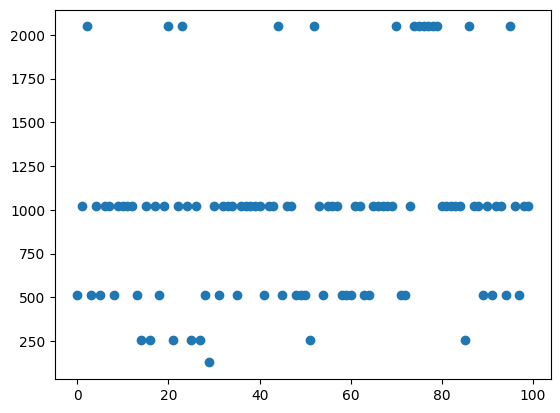

In [35]:
def plot_list(list_to_plot):
    x = range(len(list_to_plot))
    y = list_to_plot
    plt.scatter(x, y)
    plt.show()
plot_list(max_values)

In [32]:
count = 0
for i in max_values:
  if i == 2048:
    count += 1
count 

14

In [121]:
def play_game(agent):
    game = Game()
    state = preprocess(game.board)
    done = False
    while not done:
        action = agent.act(state, epsilon=0)  # set epsilon=0 to disable exploration
        act =['left', 'up', 'right', 'down'][action]
        moved, reward = game.move(act)
        if not moved:
          rand_num = action
          while rand_num == action:
            rand_num = random.randrange(4)
          act =['left', 'up', 'right', 'down'][rand_num]
          moved, reward = game.move(act)
        clear_output(wait=True)
        display_board(game.score, act, game.board)
        time.sleep(2)

        done = game.game_over
    return game.score, game.board

In [120]:
#Play the game
def play():
  agent = DQNAgent(16, 4)
  agent.model.load_state_dict(torch.load('modelv3.pth'))  # load the saved model
  score, board = play_game(agent)
  print("Game Over!")
  print("Final Score:", score)
play()

Score:  23148 	 Action: left
+-------+-------+-------+-------+
|	|	|	|	|
|  8	|  16	|  4	|  2	|
|	|	|	|	|
+-------+-------+-------+-------+
|	|	|	|	|
|  2048	|  8	|  16	|  4	|
|	|	|	|	|
+-------+-------+-------+-------+
|	|	|	|	|
|  128	|  256	|  4	|  2	|
|	|	|	|	|
+-------+-------+-------+-------+
|	|	|	|	|
|  2	|  32	|  64	|  4	|
|	|	|	|	|
+-------+-------+-------+-------+

Game Over!
Final Score: 23148
